# Human Emotions Recognition



## Project Description

**Goal**: Systematically compare baseline and advanced deep-learning models for facial expression recognition on FER-2013, and study how well the best model transfers to RAF-DB.

**Datasets**:
1. `FER-2013`
~35k grayscale images, resolution 48×48 , annotated with 7 emotions (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral). Used with a fixed train / val / test split.
2. `RAF-DB`: ~15k higher-quality RGB images, mapped to the same 7-class label space and split into train / validation / test sets. RAF is smaller but cleaner.

**Source**:

1. `FER-2013 dataset` (https://datasets.activeloop.ai/docs/ml/datasets/fer2013-dataset/),
2. `RAF-DB dataset` (https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset)

**Pipeline**:
1. `Preprocessing`
    - FER: convert DeepLake dataset to PyTorch tensors; RAF: ImageFolder + label remapping to FER indices.
    - Common transforms: resize to 48×48, grayscale, normalisation; light augmentation in train.
2. `Model Zoo on FER-2013`
    - Simple MLP, Improved MLP.
    - CNNs: Simple CNN, Improved CNN, CNN+GAP, Mini-ResNet.
    - Pretrained: ResNet18 (ImageNet) with 2-stage training:
        - train only the new FC head;
        - fine-tune the whole backbone with smaller LR.
3. `Training & evaluation on FER`
    - Unified training loop with progress bars and history (loss/accuracy per epoch).
    - Select best checkpoints by validation accuracy, evaluate on FER test set, build confusion matrices.
4. `Transfer to RAF-DB`
    - Take the best FER model (ResNet18), evaluate zero-shot on RAF-DB.
    - Further fine-tune on RAF-DB and re-evaluate; compare metrics and per-class behaviour vs FER.
5. `Final Conclusion`

*Current project was done within Advanced Programming and Deep Learning for AI course at Universita Cattolica Santo Cuore taugth by Pr. Jianyi Lin.*

## Libraries Import

In [1]:
# === Standard library ===
import os
import time
import copy
import random
import collections
from pathlib import Path
from collections import Counter

# === Scientific stack / utils ===
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# === Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Deep learning: PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import (
    random_split,
    Dataset,
    DataLoader,
    TensorDataset,
)

# === Deep learning: torchvision & d2l ===
from torchvision import transforms, datasets, models
from torchvision.transforms import functional as TF
import torchvision.transforms as T
from d2l import torch as d2l

# === Data / images / datasets ===
from PIL import Image
import deeplake

/opt/anaconda3/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.4.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

Using device: MPS (Apple GPU)


<div class="alert alert-info"; style="border-left: 7px solid SteelBlue">
<h4>⚠️ <font color="SteelBlue">Important note (TRAIN=False for fast reproducibility)</font></h4>    

This notebook is currently configured with <b>TRAIN = False</b> to ensure that it can be executed <b>quickly</b> (without multi-hour training).  
In this mode, the training cells do <b>not</b> re-train the networks; instead, the notebook <b>loads the pre-trained checkpoints</b> and the <b>saved training history</b> that I am submitting together with the notebook.

<br><br>
<b>Please place the provided files in the following folders (relative to the notebook):</b>

<br><br>
<b>1) Models/</b> (pre-trained weights + training history)
<ul>
  <li><code>mlp.pt</code></li>
  <li><code>mlp_improved.pt</code></li>
  <li><code>cnn_simple.pt</code></li>
  <li><code>cnn_improved.pt</code></li>
  <li><code>cnn_gap.pt</code></li>
  <li><code>mini_resnet.pt</code></li>
  <li><code>resnet18_fer.pt</code></li>
  <li><code>resnet18_fer_best.pt</code></li>
  <li><code>resnet18_raf.pt</code></li>
  <li><code>all_history_fer_raf.pt</code> (training curves + best validation accuracies)</li>
</ul>

<b>2) Data/FER 2013/</b>
<ul>
  <li><code>fer_train.pt</code></li>
  <li><code>fer_val.pt</code></li>
  <li><code>fer_test.pt</code></li>
</ul>

<b>3) Data/RAF-DB/</b> (required only for the RAF-DB sections)
<ul>
  <li><code>Data/RAF-DB/train/</code></li>
  <li><code>Data/RAF-DB/validation/</code></li>
  <li><code>Data/RAF-DB/test/</code></li>
</ul>

If the RAF-DB folder is not present, the notebook will raise a clear message indicating that the dataset must be downloaded from Kaggle:
<code>https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset</code>

<br><br>
<b>If you prefer to re-train everything from scratch:</b> please set <b>TRAIN = True</b> in the configuration cell below and run the notebook again from the beginning.  

</div>


In [3]:
TRAIN = False

MODELS_DIR = Path("Models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

def wpath(name: str) -> Path:
    return MODELS_DIR / f"{name}.pt"

ALL_HISTORY_PATH = MODELS_DIR / "all_history_fer_raf.pt"

all_history = None
if ALL_HISTORY_PATH.exists():
    all_history = torch.load(ALL_HISTORY_PATH, map_location="cpu")

HKEY = {
    "mlp": "mlp",
    "mlp_improved": "mlp2",
    "cnn_simple": "cnn",
    "cnn_improved": "cnn2",
    "cnn_gap": "cnn3",
    "mini_resnet": "mrn",
    "resnet18_fer": "rn18",
}

def get_hist_fer(model_file_key: str):
    if all_history is None:
        raise FileNotFoundError(f"No {ALL_HISTORY_PATH}. Put the file in Models/ or make TRAIN=True and resave.")
    return all_history["fer"][HKEY[model_file_key]]["history"]

def get_hist_raf():
    if all_history is None:
        raise FileNotFoundError(f"No {ALL_HISTORY_PATH}.")
    return all_history["raf"]["model_rn18_raf"]["history"]

def save_weights(model, name: str):
    torch.save(model.state_dict(), wpath(name))

def load_weights(model, name: str, device):
    p = wpath(name)
    if not p.exists():
        raise FileNotFoundError(f"No weights {p}. Put the file in Models/ or make TRAIN=True and create them by running the code.")
    model.load_state_dict(torch.load(p, map_location=device))
    model.to(device)
    return model

## Data Load, Exploration & Preprocessing

Importing data in the notebook:

In [4]:
DATA_DIR = Path("./Data/FER 2013")
DATA_DIR.mkdir(parents=True, exist_ok=True)

train_path = DATA_DIR / "fer_train.pt"
val_path   = DATA_DIR / "fer_val.pt"
test_path  = DATA_DIR / "fer_test.pt"

if TRAIN:
    FER_train = deeplake.load('hub://activeloop/fer2013-train')
    FER_val   = deeplake.load('hub://activeloop/fer2013-public-test')
    FER_test  = deeplake.load('hub://activeloop/fer2013-private-test')
    
    def deeplake_to_tensors(ds):
        X_list, y_list = [], []
        for sample in tqdm(ds, desc="Converting"):
            img = sample['images'].numpy()
            if img.ndim == 2:
                img = img[None, :, :]
            else:
                img = np.transpose(img, (2,0,1))
            X_list.append(img)
            y_list.append(sample['labels'].numpy().item())

        X = torch.tensor(np.stack(X_list)).float() / 255.0
        y = torch.tensor(y_list, dtype=torch.long)
        return X, y

    X_train, y_train = deeplake_to_tensors(FER_train)
    X_val,   y_val   = deeplake_to_tensors(FER_val)
    X_test,  y_test  = deeplake_to_tensors(FER_test)

    torch.save((X_train, y_train), train_path)
    torch.save((X_val,   y_val),   val_path)
    torch.save((X_test,  y_test),  test_path)

else:
    X_train, y_train = torch.load(train_path)
    X_val,   y_val   = torch.load(val_path)
    X_test,  y_test  = torch.load(test_path)

In [5]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

28709
3589
3589


As expected, ~35k images. Let us now check how many images we have for each class:

In [6]:
def count_labels_tensor(y_tensor):

    labels = y_tensor.cpu().tolist()
    counter = collections.Counter(labels)
    return counter

train_counts = count_labels_tensor(y_train)
val_counts   = count_labels_tensor(y_val)
test_counts  = count_labels_tensor(y_test)

classes = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

rows = []
for c_id, c_name in classes.items():
    rows.append({
        "class_id": c_id,
        "class_name": c_name,
        "train": train_counts.get(c_id, 0),
        "val":   val_counts.get(c_id, 0),
        "test":  test_counts.get(c_id, 0),
        "total": train_counts.get(c_id, 0) +
                 val_counts.get(c_id, 0) +
                 test_counts.get(c_id, 0),
    })

df = pd.DataFrame(rows).sort_values("class_id")
df

,class_id,class_name,train,val,test,total
0,0,Angry,3995,467,491,4953
1,1,Disgust,436,56,55,547
2,2,Fear,4097,496,528,5121
3,3,Happy,7215,895,879,8989
4,4,Sad,4830,653,594,6077
5,5,Surprise,3171,415,416,4002
6,6,Neutral,4965,607,626,6198


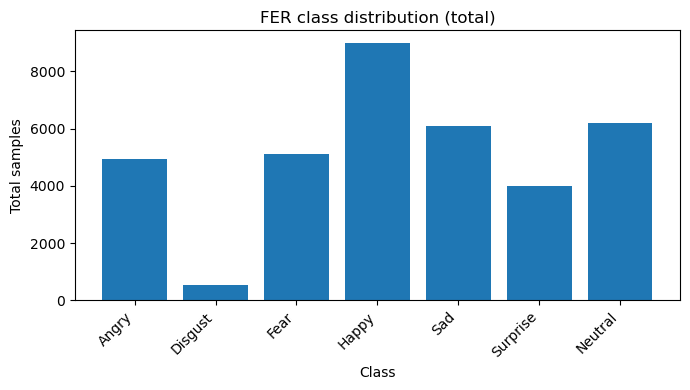

In [7]:
plt.figure(figsize=(7, 4))

plt.bar(df["class_name"], df["total"])

plt.xlabel("Class")
plt.ylabel("Total samples")
plt.title("FER class distribution (total)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

- We can observe that the `dataset is imbalanced`.
- The `Happy class` is significantly more represented than the others.
- `Disgust` is the least represented class in the dataset.

Check random image:

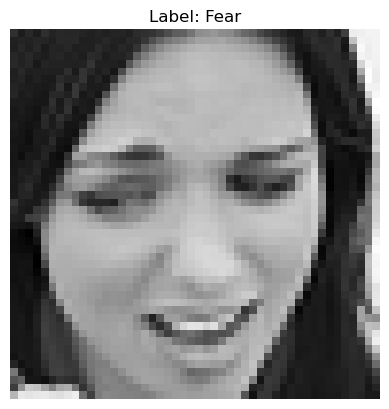

In [8]:
idx = random.randrange(len(X_train))

img   = X_train[idx].squeeze().cpu().numpy()
label = int(y_train[idx].item())

plt.imshow(img, cmap='gray')
plt.title(f"Label: {classes[label]}")
plt.axis('off')
plt.show()

### Data Preparation

Before training models let's define data augmentation, custom dataset class, and DataLoaders for training/validation/testing:

In [9]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),          # ±10°
    T.RandomResizedCrop(
        size=48, scale=(0.9, 1.1)
    ),
])

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X          # [N, C, H, W]
        self.y = y          # [N]
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        img = self.X[idx]           # torch.Tensor [C,H,W]
        label = self.y[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [11]:
train_ds = MyDataset(X_train, y_train, transform=train_transform)
val_ds   = MyDataset(X_val,   y_val)
test_ds  = MyDataset(X_test,  y_test)

train_iter = DataLoader(train_ds, batch_size=256, shuffle=True,  num_workers=0)
val_iter   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=0)
test_iter  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=0)

## MLP (baseline)

### Auxiliary functions

In [12]:
def train_epoch(model, dataloader, loss_fn, optimizer, device, epoch=None, num_epochs=None):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    desc = "Train"
    if epoch is not None and num_epochs is not None:
        desc = f"Train [{epoch}/{num_epochs}]"

    for X, y in tqdm(dataloader, desc=desc):
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [13]:
def eval_epoch(model, dataloader, loss_fn, device, epoch=None, num_epochs=None):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    desc = "Val"
    if epoch is not None and num_epochs is not None:
        desc = f"Val   [{epoch}/{num_epochs}]"

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc=desc):
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [14]:
def train(model, train_loader, val_loader, loss_fn, optimizer,
          device, num_epochs):

    model.to(device)
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(
            model, train_loader, loss_fn, optimizer, device,
            epoch=epoch, num_epochs=num_epochs
        )
        val_loss, val_acc = eval_epoch(
            model, val_loader, loss_fn, device,
            epoch=epoch, num_epochs=num_epochs
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"train_loss: {train_loss:.4f} acc: {train_acc:.4f} | "
              f"val_loss: {val_loss:.4f} acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return history

In [15]:
def plot_history(history, model_name: str | None = None):
    """
    history: dict with keys:
        'train_loss', 'val_loss', 'train_acc', 'val_acc'
    model_name: optional string for the figure title
    """
    plt.style.use("ggplot")  # modern look

    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # ----- LOSS -----
    axes[0].plot(epochs, history["train_loss"],
                 marker="o", linewidth=2, label="Train")
    axes[0].plot(epochs, history["val_loss"],
                 marker="s", linewidth=2, label="Val")
    axes[0].set_title("Loss per epoch", fontsize=11)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=9)

    # ----- ACCURACY -----
    axes[1].plot(epochs, history["train_acc"],
                 marker="o", linewidth=2, label="Train")
    axes[1].plot(epochs, history["val_acc"],
                 marker="s", linewidth=2, label="Val")
    axes[1].set_title("Accuracy per epoch", fontsize=11)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=9)

    if model_name is not None:
        fig.suptitle(model_name, fontsize=12)
        # чтобы заголовок не налезал
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        plt.tight_layout()

    plt.show()

### Model Definition & Training

A simple fully connected baseline: flatten the 48×48 image and pass it through two linear layers to produce class logits:

In [16]:
class SimpleMLP(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(1 * 48 * 48, 256),   # 2304 -> 256
            nn.ReLU(),
            nn.Linear(256, num_classes)    # 256 -> 7
        )

    def forward(self, x):
        x = self.flatten(x)   # [B, 1, 48, 48] -> [B, 2304]
        x = self.net(x)       # [B, 7] (logits)
        return x

In [17]:
model_mlp = SimpleMLP(num_classes=7).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)

In [18]:
MODEL_NAME = "mlp"

if TRAIN:
    history_mlp = train(
        model=model_mlp,
        train_loader=train_iter,
        val_loader=val_iter,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_epochs=30
    )
    save_weights(model_mlp, MODEL_NAME)
else:
    model_mlp = load_weights(model_mlp, MODEL_NAME, device)
    history_mlp = get_hist_fer(MODEL_NAME)

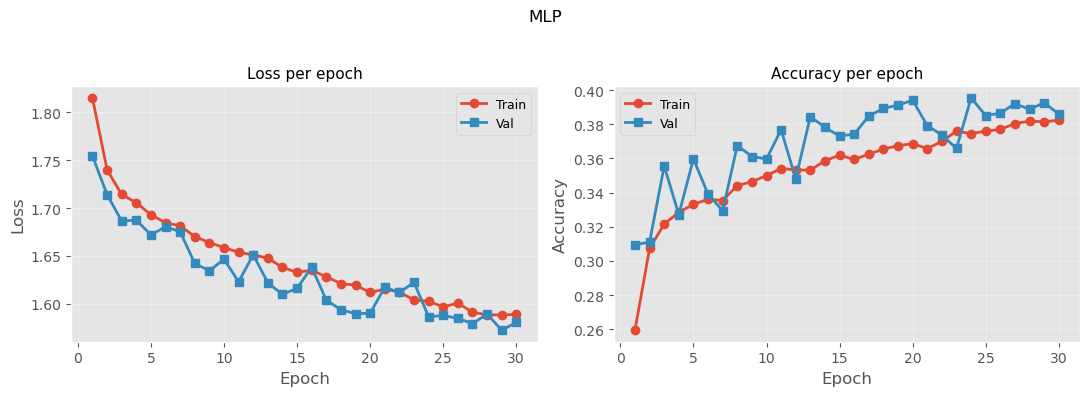

In [19]:
plot_history(history_mlp, model_name="MLP")

In [20]:
if TRAIN:
    results_fer = {}
    
    results_fer["mlp"] = {
        "history": history_mlp,
        "best_val_acc": max(history_mlp["val_acc"]),
    }

- **Learning**: Train/val loss both go down, train/val accuracy both go up, so the MLP is clearly learning signal from the data.
- **Val vs train**: Validation stays slightly better than train (loss lower, acc higher) — normal with augmentation + dropout and no sign of strong overfitting.
- **Performance**: Best val accuracy `~39.5%` - a decent baseline for an simple MLP, but there’s clear room for improved MLP / CNN / ResNet to increase metrics.

## Improved MLP

A deeper MLP baseline with BatchNorm and Dropout to improve stability and regularization:

In [21]:
class ImprovedMLP(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(1 * 48 * 48, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)   # [B, 1, 48, 48] -> [B, 2304]
        x = self.net(x)       # [B, 7]
        return x

In [22]:
model_mlp2 = ImprovedMLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp2.parameters(), lr=1e-3)

In [23]:
MODEL_NAME = "mlp_improved"

if TRAIN:
    history_mlp2 = train(
        model_mlp2,
        train_iter,
        val_iter,
        loss_fn,
        optimizer,
        device,
        num_epochs=30
    )
    save_weights(model_mlp2, MODEL_NAME)
else:
    model_mlp2 = load_weights(model_mlp2, MODEL_NAME, device)
    history_mlp2 = get_hist_fer(MODEL_NAME)

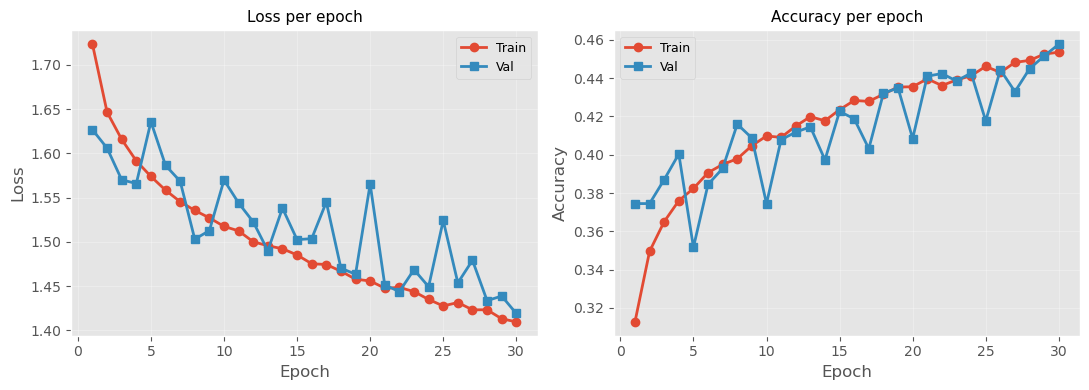

In [24]:
plot_history(history_mlp2)

In [25]:
if TRAIN:
    results_fer["mlp2"] = {
        "history": history_mlp2,
        "best_val_acc": max(history_mlp2["val_acc"]),
    }

- **Learning & stability**: Both train and val loss decrease over time, and both accuracies increase => the improved MLP is consistently learning and remains stable across `30 epochs`.
- **Generalization**: Validation accuracy peaks at `~45.8%`, clearly higher than the previous MLP (`~39.5%`), which shows a solid gain from adding BatchNorm + extra layers + Dropout.
- **Gap train vs val**: Train loss is slightly lower and train accuracy slightly higher than val in later epochs => mild overfitting, but the gap is small and acceptable.
- **Noise on val**: The jagged val curves (especially loss) reflect normal variance on the validation set; despite the noise, the trend is upward, confirming that the model generalizes better than the simpler baseline.

## CNN (baseline)

A basic CNN baseline using three conv–ReLU–pool blocks, followed by a small fully connected head for classification.

### Auxiliary functions

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            # Вход: (B, 1, 48, 48)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # -> (B, 16, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> (B, 16, 24, 24)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> (B, 32, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> (B, 32, 12, 12)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> (B, 64, 12, 12)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> (B, 64, 6, 6)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # -> (B, 64*6*6)
            nn.Linear(64 * 6 * 6, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)                  # -> (B, 7)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Model Definition & Training

In [27]:
model_cnn = SimpleCNN(num_classes=7).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

In [28]:
MODEL_NAME = 'cnn_simple'

if TRAIN:
    history_cnn = train(
    model=model_cnn,
    train_loader=train_iter,
    val_loader=val_iter,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    num_epochs=30)
    
    save_weights(model_cnn, MODEL_NAME)
else:
    model_cnn = load_weights(model_cnn, MODEL_NAME, device)
    history_cnn = get_hist_fer(MODEL_NAME)

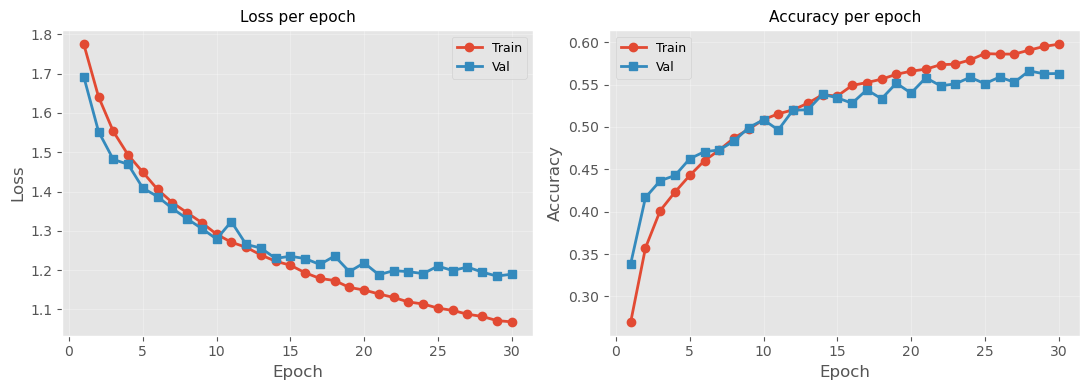

In [29]:
plot_history(history_cnn)

In [30]:
if TRAIN:
    results_fer["cnn"] = {
        "history": history_cnn,
        "best_val_acc": max(history_cnn["val_acc"]),
    }

- **Learning & stability**: Both train and val loss steadily decrease, while accuracies increase across `30 epochs` => the CNN is learning a strong and stable representation.
- **Generalization**: Validation accuracy peaks at `~56.6%`, clearly above the improved MLP (`~45.8%`) => convolutional features capture facial structure much better for given data.
- **Gap train vs val**: After ~10–15 epochs train loss keeps going down and train accuracy keeps rising, while val curves flatten => mild overfitting, but the train–val gap remains moderate and acceptable.
- **Val behavior**: Validation curves are smoother and more monotonic than for MLP => the CNN converges more reliably and is better aligned with the underlying data distribution.

## Improved CNN 1 (BatchNorm + Dropout)

A deeper CNN with double-conv blocks, BatchNorm, and Dropout to improve feature quality and regularization.

### Auxiliary functions

In [31]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1: (B, 1, 48, 48) -> (B, 32, 24, 24)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # 48 -> 24

            # Block 2: (B, 32, 24, 24) -> (B, 64, 12, 12)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # 24 -> 12

            # Block 3: (B, 64, 12, 12) -> (B, 128, 6, 6)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # 12 -> 6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                    # (B, 128*6*6)
            nn.Dropout(0.5),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Model Definition & Training

In [32]:
model_cnn2 = ImprovedCNN(num_classes=7).to(device)
optimizer = torch.optim.Adam(model_cnn2.parameters(), lr=1e-3)

In [33]:
MODEL_NAME = 'cnn_improved'

if TRAIN:
    history_cnn2 = train(
        model=model_cnn2,
        train_loader=train_iter,
        val_loader=val_iter,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_epochs=30
    )
    save_weights(model_cnn2, MODEL_NAME)
else:
    model_cnn2 = load_weights(model_cnn2, MODEL_NAME, device)
    history_cnn2 = get_hist_fer(MODEL_NAME)

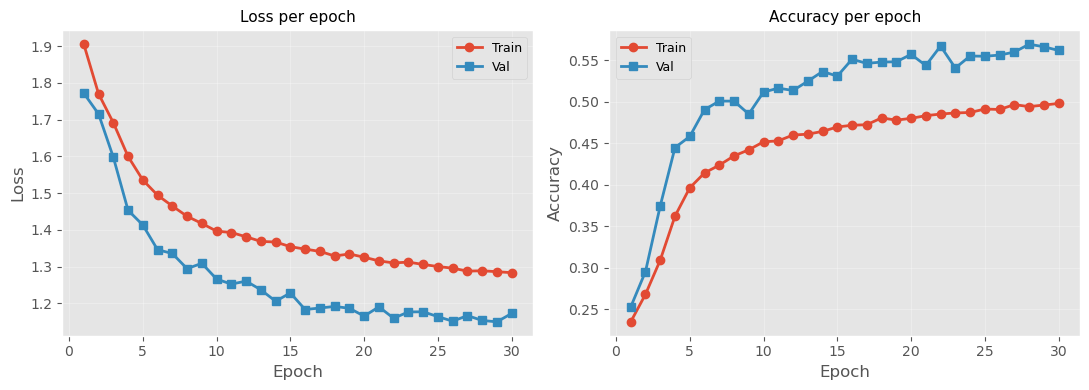

In [34]:
plot_history(history_cnn2)

In [35]:
if TRAIN:
    results_fer["cnn2"] = {
        "history": history_cnn2,
        "best_val_acc": max(history_cnn2["val_acc"]),
    }

- **Training & stability**: train and val losses decrease over `30 epochs`, while accuracy steadily increases ⇒ the improved CNN learns a strong and stable representation.
- **Generalization**: validation accuracy peaks at `~57.0%`, which is slightly higher than that of a simple CNN (`~56.6%`), demonstrating a modest but stable gain due to deeper blocks, BatchNorm, and Dropout.
- **Gap between training and validation samples**: validation accuracy remains significantly higher than training accuracy for most epochs => regularization (BatchNorm + Dropout + augmentations) makes the training task more difficult, but the model generalizes even better.
- **Val behavior**: Val curves reach a gentle plateau after ~15 epochs, with no apparent deterioration => the model is close to its current quality ceiling with this architecture and training settings.

## Improved CNN 2 (Global Average Pooling)

A CNN that replaces the fully connected head with Global Average Pooling, reducing parameters and improving generalization.

### Auxiliary functions & classes

In [36]:
class CNN_GAP(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1: 1x48x48 -> 32x24x24
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2: 32x24x24 -> 64x12x12
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3: 64x12x12 -> 128x6x6
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 4: 128x6x6 -> 256x6x6 (без пулинга, чтобы не убить spatial совсем)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)   # -> (B, 256, 1, 1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # (B, 256)
        x = self.classifier(x)
        return x

### Model Definition & Training

In [37]:
model_cnn3 = CNN_GAP(num_classes=7).to(device)
optimizer = torch.optim.Adam(model_cnn3.parameters(), lr=1e-3)

In [38]:
MODEL_NAME = 'cnn_gap'

if TRAIN:
    history_cnn_3 = train(
        model=model_cnn3,
        train_loader=train_iter,
        val_loader=val_iter,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_epochs=30
    )
    save_weights(model_cnn3, MODEL_NAME)
else:
    model_cnn3 = load_weights(model_cnn3, MODEL_NAME, device)
    history_cnn_3 = get_hist_fer(MODEL_NAME)

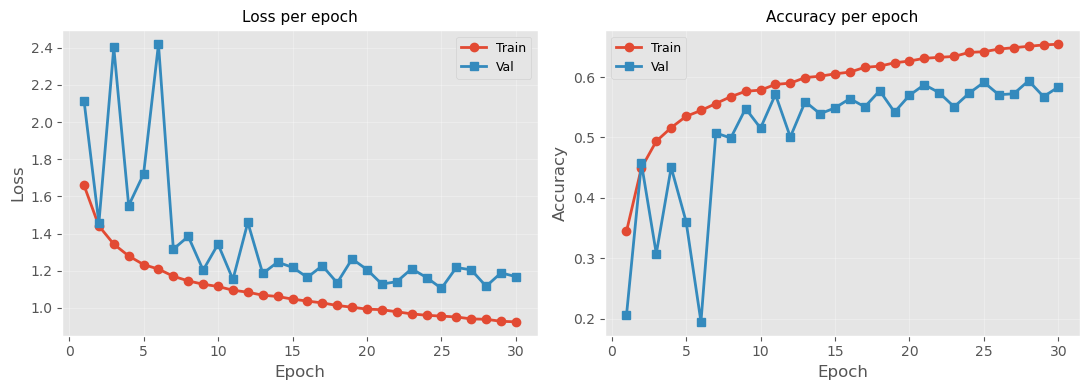

In [39]:
plot_history(history_cnn_3)

In [40]:
if TRAIN:
    results_fer["cnn3"] = {
        "history": history_cnn_3,
        "best_val_acc": max(history_cnn_3["val_acc"]),
    }

- **Learning & stability**: Train loss smoothly decreases and train accuracy grows up to `~65%`, while val accuracy also increases and stabilizes around `~58–59%` over 30 epochs.
- **Generalization**: Max validation accuracy reaches `~59.4%`, slightly better than the previous CNNs, suggesting that the GAP-based architecture captures more global, discriminative features.
- **Gap train vs val**: Train accuracy keeps improving, but val accuracy plateaus early with a consistent `~6–7 pp` gap => clear overfitting signal; stronger regularization or earlier stopping could help.
- **Val behavior**: Validation loss is very noisy in the first `~5–8 epochs`, then settles near a flat plateau => the model converges, but the early instability hints that a smaller learning rate or LR schedule might yield a smoother, possibly better optimum.

## Mini-ResNet

A lightweight ResNet-style model using residual blocks and downsampling, ending with global average pooling for classification.

### Auxiliary functions & classes

In [41]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [42]:
class MiniResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # 48x48 -> 24x24, 32 channels -> 32 channels
        self.layer1 = nn.Sequential(
            BasicBlock(32, 32, stride=1),
            BasicBlock(32, 32, stride=1),
            nn.MaxPool2d(2, 2)   # 48 -> 24
        )

        # 24x24 -> 12x12, 32 -> 64
        self.layer2 = nn.Sequential(
            BasicBlock(32, 64, stride=2),  # downsample inside block
            BasicBlock(64, 64, stride=1)
        )

        # 12x12 -> 6x6, 64 -> 128
        self.layer3 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128, stride=1)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)     # (B, 32, 48, 48)
        x = self.layer1(x)   # (B, 32, 24, 24)
        x = self.layer2(x)   # (B, 64, 12, 12)
        x = self.layer3(x)   # (B, 128, 6, 6)
        x = self.gap(x)      # (B, 128, 1, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


### Model Definition & Training

In [43]:
model_mrn = MiniResNet(num_classes=7).to(device)
optimizer = torch.optim.Adam(model_mrn.parameters(), lr=1e-3)

In [44]:
MODEL_NAME = 'mini_resnet'

if TRAIN:
    history_mrn = train(
        model=model_mrn,
        train_loader=train_iter,
        val_loader=val_iter,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_epochs=30
    )
    save_weights(model_mrn, MODEL_NAME)
else:
    model_mrn = load_weights(model_mrn, MODEL_NAME, device)
    history_mrn = get_hist_fer(MODEL_NAME)

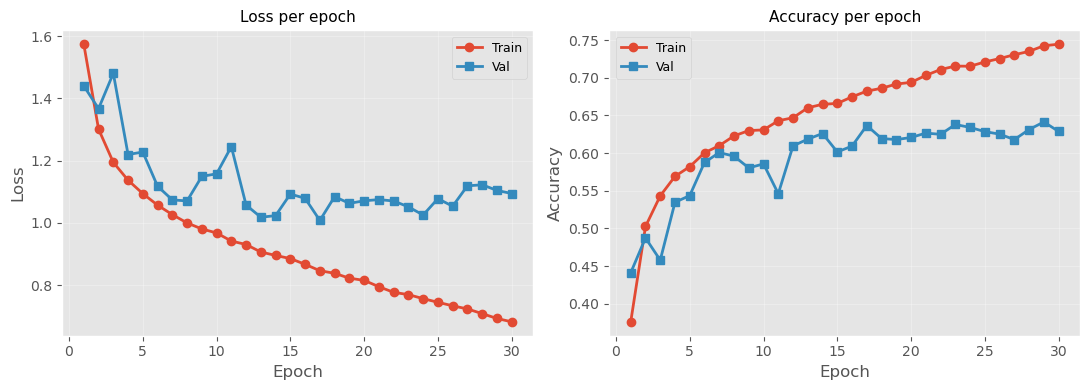

In [45]:
plot_history(history_mrn)

In [46]:
if TRAIN:
    results_fer["mrn"] = {
        "history": history_mrn,
        "best_val_acc": max(history_mrn["val_acc"]),
    }

- **Training & stability**: training losses steadily decrease, and training accuracy increases to `~75%` over 30 epochs => MiniResNet is very well suited for the training set.
- **Generalization**: maximum validation accuracy reaches `~64.1%`, which is the best among models tested so far, indicating that residual connections + a deeper feature extractor significantly improve performance.
- **Gap between train and val**: from `epoch 13` onwards, training loss continues to fall, while validation loss fluctuates around a plateau of `~1.0–1.1`, with a gap of `~5–10 pp` remaining between train_acc and val_acc => noticeable overfitting; It is logical to consider stronger regularization or early stopping.
- **Val behavior**: Validation curves are noisy, but without a clear degradation trend => the model maintains a stable level of quality, and further growth in train_acc is almost not converted into an improvement in val_acc.

## Transfer Learning

A pretrained ResNet18 adapted for FER: replace the final layer with a 7-class head, freeze the backbone, and warm up by training only the new classifier.

### Auxiliary functions & classes

In [47]:
class FERResNet18(nn.Module):
    def __init__(self, num_classes: int = 7,
                 pretrained: bool = True,
                 freeze_backbone: bool = True):
        super().__init__()

        # --- 1) load resnet18 pretrained on ImageNet (if available) ---
        if hasattr(models, "ResNet18_Weights"):
            weights = models.ResNet18_Weights.DEFAULT if pretrained else None
            backbone = models.resnet18(weights=weights)
        else:
            # older torchvision API
            backbone = models.resnet18(pretrained=pretrained)

        # --- 2) replace the last classification layer with our custom head ---
        in_features = backbone.fc.in_features
        backbone.fc = nn.Linear(in_features, num_classes)

        self.backbone = backbone

        # --- 3) optionally freeze all backbone layers except the final fc ---
        if freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if not name.startswith("fc."):
                    param.requires_grad = False

        # ImageNet mean/std for input normalization
        self.register_buffer(
            "mean",
            torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        )
        self.register_buffer(
            "std",
            torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        )

    def forward(self, x):
        # x: [B, 1, 48, 48] in range [0, 1]

        # 1) replicate grayscale channel to 3 channels (to fit ResNet input)
        x = x.repeat(1, 3, 1, 1)             # [B, 3, 48, 48]

        # 2) resize to 224x224 (default ResNet input size)
        x = F.interpolate(
            x, size=(224, 224),
            mode="bilinear", align_corners=False
        )                                   # [B, 3, 224, 224]

        # 3) normalize with ImageNet statistics
        x = (x - self.mean) / self.std

        # 4) standard forward pass through ResNet -> logits [B, num_classes]
        return self.backbone(x)

### Model Definition & Training & Fine-Tuning

In [48]:
model_rn18 = FERResNet18(
    num_classes=7,
    pretrained=True,
    freeze_backbone=True   # first, train only the classification head
).to(device)

In [49]:
MODEL_NAME = "resnet18_fer"
BEST_NAME  = "resnet18_fer_best"

if TRAIN:
    # --- Stage 1: head-only ---
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model_rn18.parameters()),
        lr=1e-3,
        weight_decay=1e-4,
    )
    num_epochs = 10

    _history_head = train(
        model=model_rn18,
        train_loader=train_iter,
        val_loader=val_iter,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
    )

    # --- Stage 2: full fine-tuning ---
    for p in model_rn18.backbone.parameters():
        p.requires_grad = True

    optimizer_finetune = torch.optim.Adam(
        model_rn18.parameters(),
        lr=1e-4,
        weight_decay=1e-4,
    )
    num_epochs_finetune = 20

    history_rn18 = train(
        model=model_rn18,
        train_loader=train_iter,
        val_loader=val_iter,
        loss_fn=loss_fn,
        optimizer=optimizer_finetune,
        device=device,
        num_epochs=num_epochs_finetune,
    )

    save_weights(model_rn18, MODEL_NAME)
    save_weights(model_rn18, BEST_NAME)

else:
    if wpath(BEST_NAME).exists():
        model_rn18 = load_weights(model_rn18, BEST_NAME, device)
    else:
        model_rn18 = load_weights(model_rn18, MODEL_NAME, device)

    history_rn18 = get_hist_fer(MODEL_NAME)

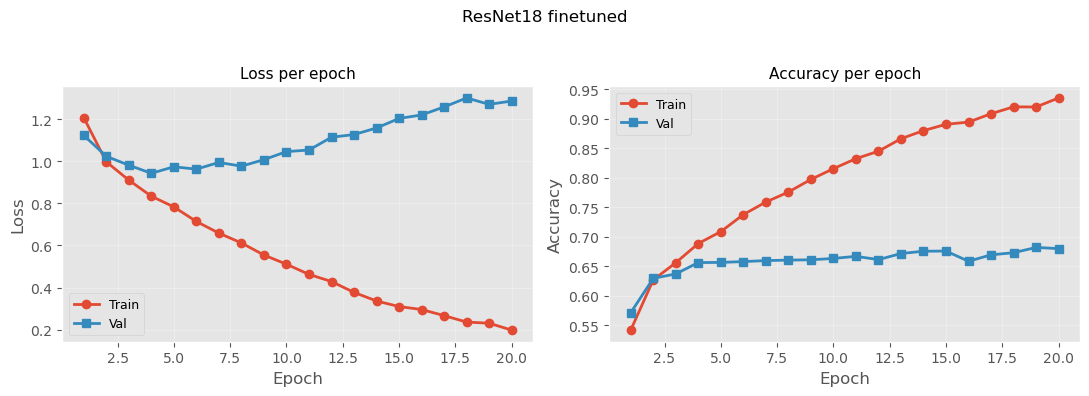

In [50]:
plot_history(history_rn18, "ResNet18 finetuned")

In [51]:
if TRAIN:
    results_fer["rn18"] = {
        "history": history_rn18,
        "best_val_acc": max(history_rn18["val_acc"]),
    }

- **Learning & stability**: training losses decrease almost monotonically, and training accuracy increases to `~94%` over `20 epochs` => a fully tuned ResNet18 network is very well suited for the training set.
- **Generalization**: validation accuracy peaks at `~68.2%`, which is significantly better than all previous fine-tuned CNNs (`~64% max.`) => ResNet18, pre-trained on ImageNet, + fine-tuning yields the strongest FER model to date.
- **Gap between training and validation / overfitting**: after `~5–7 epochs`, validation losses start to gradually increase, while training losses continue to decrease, and the gap between train_acc and val_acc increases to `~25 pp` => clear overfitting; the best checkpoint is essentially in the early epochs.
- **Fine-tuning conclusions**: the two-stage schedule (warm-up => full fine-tuning with lower LR) works, but requires early stopping or stronger regularization (more augmentations, stronger weight decay/dropout) to avoid overfitting the model.

## Evaluation and Comparison

Now let us generate a sorted comparison plot showing the best validation accuracy achieved by each FER-trained model.

### Auxiliary functions

In [52]:
def ensure_results_fer(results_fer, all_history):
    results_fer = dict(results_fer) if results_fer else {}

    if all_history is None:
        return results_fer

    for k, v in all_history["fer"].items():  # k: mlp, mlp2, cnn, cnn2, cnn3, mrn, rn18
        results_fer.setdefault(k, {
            "history": v["history"],
            "best_val_acc": v["best_val_acc"],
        })

    return results_fer

results_fer = ensure_results_fer(globals().get("results_fer", None), all_history)

### Evaluation

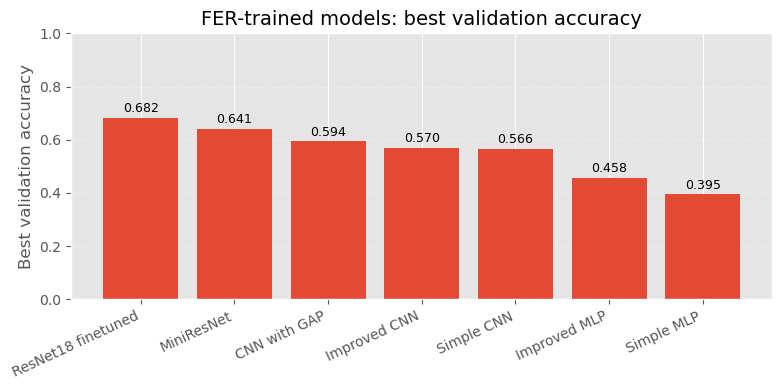

In [53]:
rows = []
for key, value in results_fer.items():
    rows.append({
        "key": key,
        "best_val_acc": float(value["best_val_acc"]),
    })

df_models = (
    pd.DataFrame(rows)
    .sort_values("best_val_acc", ascending=False)
    .reset_index(drop=True)
)

nice_names = {
    "mlp":  "Simple MLP",
    "mlp2": "Improved MLP",
    "cnn":  "Simple CNN",
    "cnn2": "Improved CNN",
    "cnn3": "CNN with GAP",
    "mrn":  "MiniResNet",
    "rn18": "ResNet18 finetuned",
}

df_models["model"] = df_models["key"].map(nice_names).fillna(df_models["key"])

plt.figure(figsize=(8, 4))

bars = plt.bar(df_models["model"], df_models["best_val_acc"])

plt.title("FER-trained models: best validation accuracy", fontsize=14)
plt.ylabel("Best validation accuracy", fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.3)

for bar, acc in zip(bars, df_models["best_val_acc"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.01, f"{acc:.3f}",
             ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

As we can see, the best model is fine-tuned ResNet18. Now let's evaluate it in the test data:

In [54]:
test_loss, test_acc = eval_epoch(
    model=model_rn18,
    dataloader=test_iter,
    loss_fn=loss_fn,
    device=device
)

print(f"ResNet18 test loss: {test_loss:.4f}")
print(f"ResNet18 test accuracy: {test_acc:.4f}")

Val:   0%|          | 0/15 [00:00<?, ?it/s]

ResNet18 test loss: 1.1669
ResNet18 test accuracy: 0.6971


Final accuracy score for best model is `0.6971`.

Let's have a look at the **confusion metrix** to know in which classes prediction is more reliable:

In [55]:
model_rn18.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_iter:
        X = X.to(device)
        y = y.to(device)

        logits = model_rn18(X)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(y.cpu().tolist())

all_preds = torch.tensor(all_preds)
all_targets = torch.tensor(all_targets)

In [56]:
num_classes = 7
cm = confusion_matrix(all_targets.numpy(), all_preds.numpy(),
                      labels=np.arange(num_classes))

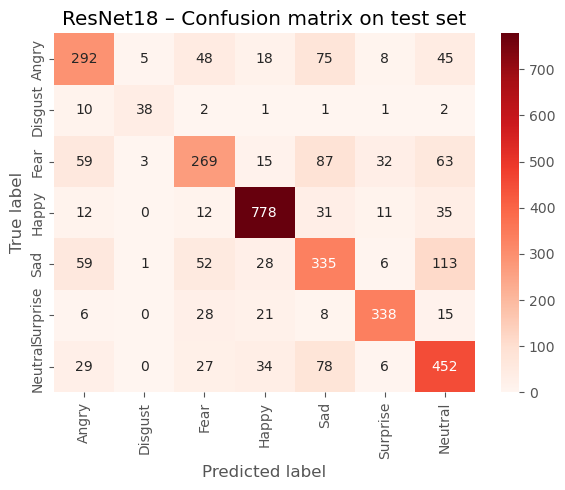

In [57]:
class_names = [classes[i] for i in range(num_classes)]

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Reds",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("ResNet18 – Confusion matrix on test set")
plt.tight_layout()
plt.show()

- Strong accuracy on `Happy`, `Neutral`, and `Surprise` - the most common classes.
- Noticeable confusion among Fear, Sad, and Angry.
- `Disgust` is poorly recognized due to very few training samples.
- Overall error patterns clearly reflect the `class imbalance` in FER-2013.

## Model Generalization Check on RAF-DB Dataset

We load RAF-DB, remap its labels to FER indices, and apply the same preprocessing so we can test FER-trained models on RAF-DB and fine-tune them further on this dataset for improved cross-dataset performance.

### Data Load and Transformation

In [58]:
RAF_ROOT = Path("Data/RAF-DB")
required = {
    "train": RAF_ROOT / "train",
    "validation": RAF_ROOT / "validation",
    "test": RAF_ROOT / "test",
}

missing = [name for name, p in required.items() if not p.exists()]
if missing:
    raise FileNotFoundError(
        "RAF-DB dataset folders were not found:\n"
        + "\n".join([f" - {k}: {required[k]}" for k in missing])
        + "\n\nPlease download the dataset from Kaggle:\n"
        + "https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset\n\n"
        + "Then extract/copy it so the folder structure looks like:\n"
        + f"{RAF_ROOT}/train/\n{RAF_ROOT}/validation/\n{RAF_ROOT}/test/\n"
        + "(each containing class subfolders: angry, disgust, fear, happy, sad, surprise, neutral)\n"
    )

In [59]:
IMG_SIZE = 48
BATCH_SIZE = 256

train_transform = transforms.Compose([
    transforms.Grayscale(),                       # keep if FER was grayscale
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # set to FER mean/std
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- 1. Base datasets from folders ---
raf_train_base = datasets.ImageFolder(os.path.join(RAF_ROOT, "train"),      transform=train_transform)
raf_val_base   = datasets.ImageFolder(os.path.join(RAF_ROOT, "validation"), transform=test_transform)
raf_test_base  = datasets.ImageFolder(os.path.join(RAF_ROOT, "test"),       transform=test_transform)

# --- 2. Build mapping RAF idx -> FER idx ---
fer_class_to_idx = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

raf_class_to_idx = raf_train_base.class_to_idx
idx_remap = {raf_class_to_idx[cls]: fer_class_to_idx[cls] for cls in raf_class_to_idx.keys()}

# --- 3. Wrapper dataset that remaps labels ---
class MappedDataset(Dataset):
    def __init__(self, base_ds, idx_remap):
        self.base_ds = base_ds
        self.idx_remap = idx_remap

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        img, label = self.base_ds[idx]
        mapped_label = self.idx_remap[label]
        return img, mapped_label

raf_train_ds = MappedDataset(raf_train_base, idx_remap)
raf_val_ds   = MappedDataset(raf_val_base,   idx_remap)
raf_test_ds  = MappedDataset(raf_test_base,  idx_remap)

# --- 4. DataLoaders (same as before, but with mapped datasets) ---
raf_train_iter = DataLoader(raf_train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
raf_val_iter   = DataLoader(raf_val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
raf_test_iter  = DataLoader(raf_test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### Dataset Overview

In [60]:
print(len(raf_train_ds), len(raf_val_ds), len(raf_test_ds), sep='\n')

12271
1533
1535


In [61]:
def count_labels_dataset(ds):
    counter = collections.Counter()
    for img, label in ds:
        counter[int(label)] += 1
    return counter

raf_train_counts = count_labels_dataset(raf_train_ds)
raf_val_counts   = count_labels_dataset(raf_val_ds)
raf_test_counts  = count_labels_dataset(raf_test_ds)

classes = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

rows = []
for c_id, c_name in classes.items():
    rows.append({
        "class_id": c_id,
        "class_name": c_name,
        "train": raf_train_counts.get(c_id, 0),
        "val":   raf_val_counts.get(c_id, 0),
        "test":  raf_test_counts.get(c_id, 0),
        "total": raf_train_counts.get(c_id, 0) +
                 raf_val_counts.get(c_id, 0) +
                 raf_test_counts.get(c_id, 0),
    })

df_raf = pd.DataFrame(rows).sort_values("class_id")
df_raf

,class_id,class_name,train,val,test,total
0,0,Angry,705,81,81,867
1,1,Disgust,717,80,80,877
2,2,Fear,281,37,37,355
3,3,Happy,4772,592,593,5957
4,4,Sad,1982,239,239,2460
5,5,Surprise,1290,164,165,1619
6,6,Neutral,2524,340,340,3204


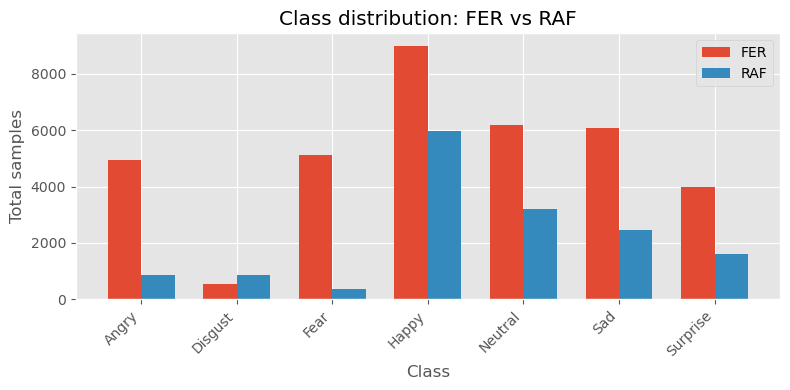

In [62]:
merged = df[["class_name", "total"]].merge(
    df_raf[["class_name", "total"]],
    on="class_name",
    suffixes=("_fer", "_raf")
).sort_values("class_name")

classes = merged["class_name"].tolist()
fer_counts = merged["total_fer"].values
raf_counts = merged["total_raf"].values

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8, 4))

plt.bar(x - width/2, fer_counts, width, label="FER")
plt.bar(x + width/2, raf_counts, width, label="RAF")

plt.xlabel("Class")
plt.ylabel("Total samples")
plt.title("Class distribution: FER vs RAF")
plt.xticks(x, classes, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

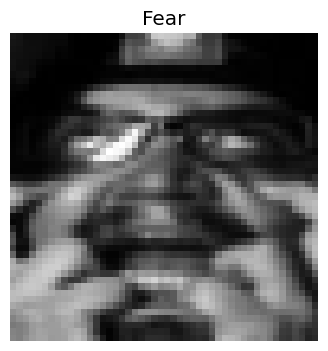

In [63]:
idx = random.randint(0, len(raf_train_ds) - 1)
img, mapped_label = raf_train_ds[idx]

img_show = img * 0.5 + 0.5

if img_show.dim() == 3 and img_show.size(0) == 1:
    img_show = img_show.squeeze(0)

img_pil = TF.to_pil_image(img_show)

plt.figure(figsize=(4, 4))
plt.imshow(img_pil, cmap="gray")
plt.title(f"{classes[mapped_label]}")
plt.axis("off")
plt.show()


- **Dataset size**: FER is roughly `2x` larger than RAF (`~35k` vs `~15k` images), so models trained only on FER see more total examples.
- **Shared strong bias to “positive/neutral”**: In both datasets, Happy, Neutral and Sad dominate (especially Happy).
- **Minority emotions**: Disgust and Fear are clear minority classes in both datasets. RAF is extremely low on Fear (355 images total), which will make this class noisy and hard to learn when fine-tuning on RAF.
- **Overall**: RAF is smaller and more imbalanced, but its distribution is still broadly similar, which is why transfer from FER => RAF is reasonable, especially for the dominant classes.

### Before Fine-Tuning Model Evaluation

Evaluate the FER-trained ResNet18 on RAF-DB before any fine-tuning to measure its zero-shot cross-dataset performance.

In [64]:
model_rn18_raf = FERResNet18(
    num_classes=7,
    pretrained=False,      
    freeze_backbone=False
).to(device)

model_rn18_raf = load_weights(model_rn18_raf, "resnet18_fer_best", device)

Check without fine-tuning on FER Test Set:

In [65]:
raf_test_loss_before, raf_test_acc_before = eval_epoch(model_rn18_raf, raf_test_iter, loss_fn, device)
print(f"[Before fine-tuning] RAF test loss: {raf_test_loss_before:.4f}, "
      f"RAF test acc: {raf_test_acc_before:.4f}")

Val:   0%|          | 0/6 [00:00<?, ?it/s]

[Before fine-tuning] RAF test loss: 5.2131, RAF test acc: 0.2990


- A **ResNet** model fine-tuned on **FER2013** and achieved `~69%` accuracy (model_rn18) was evaluated on **RAF-DB**, achieving only `~30%`.
- That can indicate weak generalizabily but to be more confident let's fine-tune it on **RAF-DB**

### Fine-Tuning on RAF-DB Train Set

Fine-tune the FER-pretrained ResNet18 on the RAF-DB training set to adapt its features to the new dataset and improve cross-dataset accuracy.

In [66]:
MODEL_NAME = "resnet18_raf"

loss_fn_raf = nn.CrossEntropyLoss()

if TRAIN:
    optimizer_raf = torch.optim.Adam(
        model_rn18_raf.parameters(),
        lr=1e-4,
        weight_decay=1e-4,
    )

    history_rn18_raf = train(
        model=model_rn18_raf,
        train_loader=raf_train_iter,
        val_loader=raf_val_iter,
        loss_fn=loss_fn_raf,
        optimizer=optimizer_raf,
        device=device,
        num_epochs=15,
    )

    save_weights(model_rn18_raf, MODEL_NAME)

else:
    model_rn18_raf = load_weights(model_rn18_raf, MODEL_NAME, device)
    history_rn18_raf = get_hist_raf()

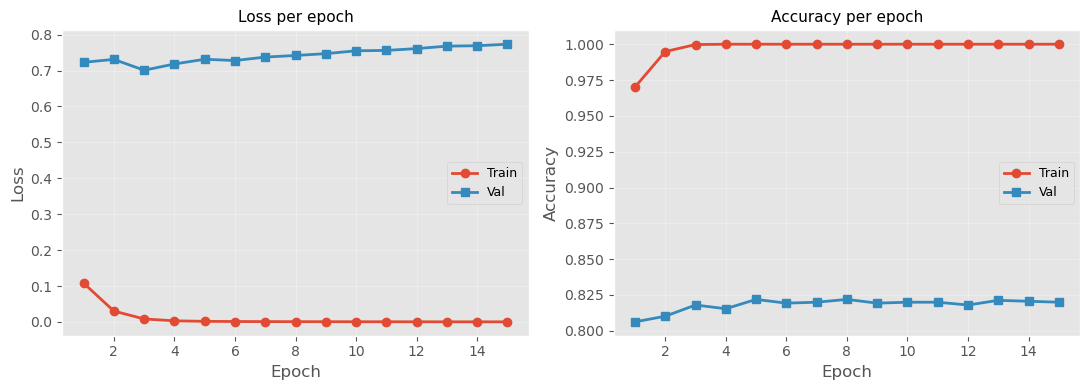

In [67]:
plot_history(history_rn18_raf)

In [68]:
if TRAIN:
    results_raf = {}
    
    results_raf["model_rn18_raf"] = {
        "history": history_rn18_raf,
        "best_val_acc": max(history_rn18_raf["val_acc"]),
    }

Evaluate the fine-tuned ResNet18 on the RAF-DB test set to quantify the accuracy gain after training on RAF-DB.

In [69]:
raf_test_loss_after, raf_test_acc_after = eval_epoch(
    model_rn18_raf, raf_test_iter, loss_fn_raf, device
)
print(f"[After fine-tuning] RAF test loss: {raf_test_loss_after:.4f}, "
      f"RAF test acc: {raf_test_acc_after:.4f}")

Val:   0%|          | 0/6 [00:00<?, ?it/s]

[After fine-tuning] RAF test loss: 0.6349, RAF test acc: 0.8221


- After fine-tune on **RAF-DB**, we `~82%` on RAF test and `~100%` on RAF train.

### Evaluation on FER Test Set

Evaluate the fine-tuned model on the FER test split to measure how much performance improved after adapting to RAF-DB.

In [70]:
raf_test_loss_after, raf_test_acc_after = eval_epoch(
    model_rn18_raf,
    test_iter,
    loss_fn_raf,
    device
)
print(f"[After fine-tuning] FER test loss: {raf_test_loss_after:.4f}, "
      f"FER test acc: {raf_test_acc_after:.4f}")

Val:   0%|          | 0/15 [00:00<?, ?it/s]

[After fine-tuning] FER test loss: 2.4567, FER test acc: 0.5408


- After this fine-tuning, accuracy on **FER2013** dropped to `~54%` compared to model_rn18 fine-tuned only on FER.

### Intermediate Conclusions

- Strong performance on **RAF-DB** (`82%` test, `100%` train) indicates **overfitting on RAF**.  
- Performance on **FER2013** degraded from `69%` → `54%`, showing **catastrophic forgetting**.  
- Large gap between FER (`69%`) and RAF (`30%`) indicates severe **domain shift** between datasets.

*a. Domain Shift*
- FER2013 and RAF-DB differ in image quality, color, face alignment, class distribution, and labeling quality.  
- A representation optimal for FER does not transfer well to RAF.

*b. Overfitting on RAF-DB*
- Achieving `100%` on RAF train shows the model memorized dataset-specific patterns (faces, lighting, backgrounds).  
- This reduces generalization and harms performance on other datasets.

*c. Catastrophic Forgetting*
- Fine-tuning exclusively on RAF forces the model to overwrite feature representations learned on FER.  
- As a result, FER performance drops significantly.

*d. Conflicting Optimal Solutions*
- FER and RAF require different decision boundaries.  
- Optimizing for one naturally deteriorates performance on the other without joint training.

**Recommendations for Further Development**

*1. Joint Training*
- Train on **FER + RAF** simultaneously (balanced mixing) to prevent forgetting and handle domain variation.

*2. Freeze Lower Layers During Fine-Tuning*
- Freeze early convolutional blocks and train only top layers to reduce catastrophic forgetting.

*3. Require Hyperparameter Tuning, Regularization, and Early Stopping*
- Strengthen **regularization** (dropout, weight decay, data augmentation).  
- Use thorough **hyperparameter tuning** (learning rate, batch size, number of unfrozen layers).  
- Apply **early stopping** to prevent overfitting on RAF and preserve generalization across datasets.

*4. Improve Data Alignment*
- Use augmentations and preprocessing to make FER and RAF more stylistically consistent.

## Saving Results

To proceed saving uncomment the following:

In [71]:
if TRAIN:
    all_history = {
        "fer": results_fer,
        "raf": results_raf,
    }

    torch.save(all_history, ALL_HISTORY_PATH)  # -> Models/all_history_fer_raf.pt

## Final Conclusion

**Model capacity and inductive bias matter.**

Simple MLPs on raw pixels reach only ~40–46% validation accuracy on FER-2013. Moving to convolutional architectures immediately boosts performance into the mid-50s to high-50s, confirming that CNNs are much better suited for images than fully-connected baselines.

**Modern CNN tricks give consistent gains.**

Adding BatchNorm, Dropout, deeper blocks, GAP, and residual connections steadily improves results: the Mini-ResNet reaches ≈64% validation accuracy on FER, clearly outperforming simpler CNNs and demonstrating the benefit of residual learning even at small scale.

**Pretraining is the strongest single lever.**

Fine-tuning ResNet18 pretrained on ImageNet pushes FER-2013 performance further, to roughly 68% validation accuracy and about 70% test accuracy. The training curves show good convergence and a reasonable train–val gap, indicating that pretraining plus moderate regularisation gives the best trade-off between fit and generalisation.

**Class imbalance and dataset bias remain challenging.**

Confusion matrices show that some emotions (Disgust, Fear, sometimes Surprise) are consistently under-recognised compared with Happy and Neutral, reflecting both label imbalance and the subjective difficulty of those expressions. This pattern appears on both FER and RAF.

**Cross-dataset transfer is non-trivial.**

The FER-trained ResNet18 performs poorly zero-shot on RAF-DB despite strong FER results, highlighting a substantial domain shift (differences in image quality, pose, and expression style). After fine-tuning on RAF-DB the accuracy increases markedly, but still lags behind the FER numbers, indicating that:
- pretraining on large generic data (ImageNet) helps,
- but dataset-specific fine-tuning is necessary for good performance,
- and full robustness across emotion datasets is not solved by architecture alone.

**Takeaways for future development.**

- Use pretrained CNNs / ResNets as a default backbone for facial expression tasks.
- Combine better rebalancing strategies (class-weighted loss, oversampling) with stronger augmentation to address minority emotions.
- Explore joint training on FER + RAF or domain-adaptation techniques to improve cross-dataset generalisation.

**In summary**, the project shows a clear progression: from weak MLP baselines to stronger custom CNNs, and finally to a pretrained ResNet18 that delivers the best performance on FER and a solid starting point for transfer to RAF-DB, while also exposing the real-world challenges of domain shift and class imbalance in facial expression recognition.